In [1]:
import numpy as np
from vizdoom import *
import random
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import sys

def create_environment():
    game = DoomGame()
    game.load_config('vizdoom/myConfig.cfg')  
    game.set_doom_scenario_path('vizdoom/square.wad')
    #game.set_doom_scenario_path('vizdoom/tmaze.wad')
    #game.set_doom_map('map01')
    game.set_mode(Mode.PLAYER)
    game.set_window_visible(False)
    game.set_automap_buffer_enabled(True)
    game.set_automap_mode(WHOLE)
    game.set_available_buttons([MOVE_LEFT, MOVE_RIGHT, MOVE_FORWARD, MOVE_BACKWARD, TURN_RIGHT]) 
    #game.set_available_buttons([MOVE_FORWARD, MOVE_BACKWARD, TURN_RIGHT, TURN_LEFT]) 
    game.set_available_game_variables([POSITION_X, POSITION_Y, ANGLE, VELOCITY_X, VELOCITY_Y, CAMERA_FOV])
    game.init()     
    return game

### moving functions ###
def move(game, action, speed=1):
    game.make_action(action, speed)
    v = [game.get_game_variable(VELOCITY_X), game.get_game_variable(VELOCITY_Y)]
    game.make_action([0]*game.get_available_buttons_size(), 50)
    return v

def randMove(game, avoidWall=False, speed=1):
    actions = np.identity(game.get_available_buttons_size(), dtype = int)
    mask = np.ones(game.get_available_buttons_size(), dtype=bool)
    if mask.size > 4:
        mask[4] = False # TURN_RIGHT
    if avoidWall:
        pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
        if pos[0] > 150:
            mask[2] = False # inhibit MOVE_FORWARD
        if pos[0] < -150:
            mask[3] = False # inhibit MOVE_BACKWARD
        if pos[1] > 150:
            mask[0] = False # inhibit MOVE_LEFT
        if pos[1] < -150:
            mask[1] = False # inhibit MOVE_RIGHT
    actions = actions[mask].tolist()
    action = random.choice(actions)
    return move(game, action, speed), action

### plotting ###
def compute_receptive_field(act, x, y, bin_size):
    # batch size and the number of neurons
    num_neuron = act.shape[0];
    # sampling size for gaussian smoothing
    sample_size = int(np.minimum(bin_size[0], bin_size[1]) / 4);
    if sample_size % 2 == 0 :
        sample_size += 1;
    
    # receptive field
    receptive_fields = np.zeros((num_neuron, bin_size[1], bin_size[0]));
    # compute receptive field with spatial position
    map_x = x.reshape(-1);
    map_y = y.reshape(-1);
    for neuron_idx in np.arange(num_neuron):
        f = act[neuron_idx, :].reshape(-1);
        ratemap, _, _, _ = stats.binned_statistic_2d(map_y, map_x, f, 
                                                     statistic = lambda x : np.mean(x),
                                                     bins = [bin_size[1], bin_size[0]]);
        # Nan value complete
        ratemap_nan = np.copy(ratemap);
        nan_idx = np.where(np.isnan(ratemap_nan));
        
        # gaussian sampling 
        ratemap_nan[nan_idx] = 0.0;
        ratemap_nan = cv2.GaussianBlur(ratemap_nan, (sample_size, sample_size), 0);
        ratemap[nan_idx] = ratemap_nan[nan_idx];
        receptive_fields[neuron_idx] = ratemap;
    return receptive_fields;

def plot_receptive_field(activity, traj, plot_size=[1,1], bin_length=50, fig_size=[10,10]):
    ratemaps = compute_receptive_field(activity, traj[:, 0], traj[:, 1], [int(traj[:, 0].size/bin_length), int(traj[:, 1].size/bin_length)]);
    num_neuron = ratemaps.shape[0];
    plt.figure(figsize=fig_size);
    #plt.axis('off');
    for neuron_idx in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0], plot_size[1], neuron_idx + 1);
        plt.imshow(np.flipud(ratemaps[neuron_idx]), interpolation = 'gaussian');
    plt.show();

def plot_traj(traj, env_range=[(-200, 200), (-200, 200)]):
    #print((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #print((np.max(traj[:, 1]), np.min(traj[:, 1])));
    plt.figure();
    plt.subplot(1, 1, 1);
    plt.plot(traj[:, 0], traj[:, 1], 'ko-');
    plt.xlim(env_range[0]);
    plt.ylim(env_range[1]);
    #plt.xlim((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #plt.ylim((np.min(traj[:, 1]), np.max(traj[:, 1])));
    #plt.axis('scaled');
    #plt.axis('off');
    plt.title('Trajectory');
    plt.show();

In [2]:
### primary visual cortex ###
import cv2
from scipy.ndimage.interpolation import shift

def downsample(img, size):
    res = np.zeros([int(img.shape[0]/size), int(img.shape[1]/size)])
    for y in range(int(img.shape[0]/size)):
        for x in range(int(img.shape[1]/size)):
            res[y, x] = np.average(img[y*size: (y+1)*size, x*size: (x+1)*size])
    return res

class V1:
    def __init__(self, initState, kernel_size=20):   
        self.kernel_size = kernel_size
        self.height = initState.shape[0] # input image size
        self.width = initState.shape[1]
        self.vn_height = int(self.height/self.kernel_size*2)
        self.vn_width = int(self.width/self.kernel_size*2)
        self.nNeurons = self.vn_height * self.vn_width
        self.data = np.zeros([0, self.nNeurons])
        
    def response(self, state, angle=0.0): 
        #print(state) # shape: (480, 640)
        #cv2.imwrite('state_original.jpg', state);        
        # Gabor filter
        filter_outputs = np.zeros([0, self.vn_height, self.vn_width])
        for i in range(4):
            g_kernel = cv2.getGaborKernel((self.kernel_size, self.kernel_size), sigma=8.0, theta=np.pi/4.0*i, lambd=15.0, gamma=1.5, psi=0)
            #cv2.imwrite('kernel.jpg', g_kernel*255/np.max(g_kernel));
            filter_output = downsample(cv2.filter2D(state, cv2.CV_8UC3, g_kernel), int(self.kernel_size/2))
            filter_outputs = np.append(filter_outputs, filter_output.reshape([1, self.vn_height, self.vn_width]), axis=0)
            #cv2.imwrite('filter_output'+str(i)+'.jpg', filter_output);
        filtered_state = np.amax(filter_outputs, axis=0).reshape([self.vn_height, self.vn_width])
        #cv2.imwrite('state_filtered.jpg', filtered_state);
        
        # 2D to 1D
        filtered_state = filtered_state.reshape((1, -1)) # shape => (1, vn_height * vn_width)
        # sum normalization (-> length unity)
        filtered_state = filtered_state / np.max(filtered_state)
        filtered_state = filtered_state / np.tile(np.linalg.norm(filtered_state, axis=1).reshape((-1, 1)), (1, filtered_state.shape[1]))
        
        self.data = np.append(self.data, filtered_state, axis=0)
        return filtered_state

In [3]:
### Grid Cell Sheet ###
sin60 = np.sqrt(3)/2.0

class GCSheet:
    def __init__(self, N, Ncpc=0, cpc=0):
        self.Nx = int(round(np.sqrt(N/sin60)))
        self.Ny = int(round(self.Nx * sin60))
        self.N = self.Nx * self.Ny
        #print(self.Nx, self.Ny)
        
        self.poses = [[i+1, j+1] for i in range(self.Nx) for j in range(self.Ny)] #poses[n-1] = [int(n/self.Ny)+1, n%self.Ny]
        self.alpha = np.random.uniform(1.0/400, 2.6/400) # smaller -> larger spacing # [1,3]
        print(self.alpha*400)
        self.beta = np.random.uniform(0, np.pi/3)
        self.R = np.array([[np.cos(self.beta), -np.sin(self.beta)], [np.sin(self.beta), np.cos(self.beta)]])
        
        self.A = np.random.uniform(0, 1/np.sqrt(self.N), self.N) # initial activity
        self.updateW([0, 0]) # initial weights
        
        self.cpc = cpc
        self.Wcpc = np.random.rand((Ncpc, N))
        self.Wcpc /= np.tile(np.sqrt(np.sum(self.Wcpc * self.Wcpc, axis = 0)), (Ncpc, 1))
        
    def distTri(self, i, j, v): # i, j are [x,y], where 1<=x<=Nx, 1<=y<=Ny
        ci = np.array([(i[0]-0.5)/self.Nx, (i[1]-0.5)/self.Ny*sin60])
        cj = np.array([(j[0]-0.5)/self.Nx, (j[1]-0.5)/self.Ny*sin60])
        s = np.array([[0,0],[-0.5,sin60],[-0.5,-sin60],[0.5,sin60],[0.5,-sin60],[-1,0],[1,0]])
        return np.min(np.linalg.norm(np.tile(ci, (7,1)) - np.tile(cj, (7,1)) + np.tile(v, (7,1)) + s, axis=1))
        
    def dynamic(self, Acpc):
        tau = 0.8
        B = np.matmul(self.w, self.A.T)
        self.A = (1-self.cpc) * np.clip((1-tau)*B + tau*B/np.sum(self.A), 0, None) + self.cpc * np.dot(Acpc, self.Wcpc)
        
    def updateW(self, v): # v: [vx, vy]
        I = 0.3
        T = 0.05
        sigma = 0.25 # unit: meter # 0.24
        
        v = self.alpha * np.matmul(self.R, np.array(v).T)
        self.w = np.array([[I * np.exp(-(self.distTri(i,j,v)**2)/sigma**2) - T for i in self.poses] for j in self.poses])
        self.w *= np.ones(self.w.shape) - np.identity(self.N) # eliminate self-recurrent?

class GCpop:
    def __init__(self, N, Nsheets):
        self.Nneurons = N*Nsheets
        self.sheets = []
        for i in range(Nsheets):
            self.sheets.append(GCSheet(N))
            for t in range(300):
                self.sheets[-1].dynamic()
        self.data = np.zeros((0, self.Nneurons))
                
    def updateW(self, v):
        for s in self.sheets:
            s.updateW(v)
            
    def dynamic(self, record=False):
        for s in self.sheets:
            s.dynamic()
        res = np.array([s.A for s in self.sheets]).reshape((1, self.Nneurons))
        if record:
            self.data = np.append(self.data, res, axis=0)
        return res

In [45]:
### visual/motion place cells (with competitive learning) ###

class PlaceCell: 
    def __init__(this, N, nDim, eta=0.2, inFilter=1, noise=0.003): 
        this.inFilter = 1.0-inFilter # for MPC
        this.noise = noise
        this.eta = eta;
        #this.mapSize = mapSize; # 2D size of number of place fields
        this.nDim = nDim; # number of pixels of visual input; number of motion grid cells
        this.nNodes = N
        
        # create weight space
        this.w = np.random.rand(this.nDim, this.nNodes);
        # normalize the weight
        this.w = this.w / np.tile(np.sqrt(np.sum(this.w * this.w, axis = 0)), (this.nDim, 1));
        
        this.data = np.zeros([0, this.nNodes])

    def train(this, sample, nIter=1):
        for iterIdx in range(nIter):
            winIdx, neuronOutput = this.computeWinNeuron(sample);
            if this.inFilter>0:
                this.updateWeight(np.clip(sample-np.amax(sample)*this.inFilter*np.ones(sample.shape), 0, None), winIdx, neuronOutput);
            else:
                this.updateWeight(sample, winIdx, neuronOutput);

    def computeWinNeuron(this, neuronInput):
        # forward output
        neuronOutput = np.dot(neuronInput, this.w)
        # add some noise
        winIdx = np.argmax(neuronOutput + np.amax(neuronOutput) * this.noise * this.nNodes * np.random.rand(1, this.nNodes));
        return winIdx, neuronOutput;
    
    def updateWeight(this, neuronInput, winIdx, neuronOutput):
        # on-line update the winning neuron weight
        this.w[:, winIdx: winIdx+1] += this.eta * neuronInput.T * neuronOutput[0, winIdx];
        # normalization
        if np.sum(this.w[:, winIdx]) != 0:
            this.w[:, winIdx] = this.w[:, winIdx] / np.sqrt(np.sum(this.w[:, winIdx] * this.w[:, winIdx]));
        
    def estimate(this, x, e=0.925, record=False):
        # forward output
        y = np.dot(x, this.w);
        # E% max inhibition
        y = y - e * np.tile(np.reshape(np.max(y, 1), [-1, 1]), [1, y.shape[1]]);
        y = y * (y > 0);
        y = y / (1.0 - e);
        if record:
            this.data = np.append(this.data, y, axis=0)
        return y;

In [61]:
### Conjunctive Place Cell ###

class CPC: 
    def __init__(self, N, nVPC, nMPC, eta=1, noise=0.003, alpha=0.3, inFilter=1):
        self.alpha = alpha
        self.eta = eta
        self.noise = noise
        self.w = np.random.rand(nVPC+nMPC, N)
        self.w = self.w / np.tile(np.sqrt(np.sum(self.w * self.w, axis = 0)), (nVPC+nMPC, 1))
        self.data = np.zeros([0, N])
        self.obj = PlaceCell(N, nVPC+nMPC, eta=eta, noise=noise, inFilter=inFilter)

    def train(self, actV, actM, nIter=1):
        self.obj.train(np.concatenate((self.alpha*actV, (1-self.alpha)*actM), axis=1), nIter)
                 
    def estimate(self, actV, actM, e=0.0, record=False):
        self.obj.estimate(np.concatenate((self.alpha*actV, (1-self.alpha)*actM), axis=1), e=e, record=record)


1.317746519
1.72912158044
1.26205148813
2.19192709258
1.95002536012
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

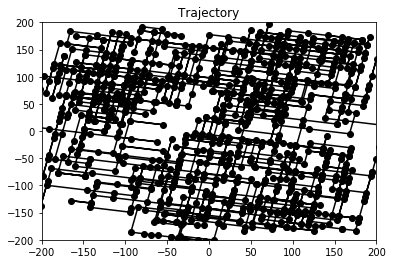

In [62]:
### main / exploration ###

game = create_environment()
game.new_episode()
game.make_action([0, 0, 0, 0, 1], 10)
game.make_action([0, 0, 0, 0, 0], 100)

pos = [0,0]
traj = []
env_range = [[-190, 190], [-190, 190]]

## V1 ##
v1 = V1(game.get_state().screen_buffer)
Av1 = v1.response(game.get_state().screen_buffer)

## Visual Place Cells ##
vpc = PlaceCell(225, v1.nNeurons, eta=3, noise=0.010)
Avpc = vpc.estimate(Av1, e=0.6)

## Motion Grid Cells ##
nSteps = 5
mgc = GCpop(90, 5)
Amgc = mgc.dynamic()

## Motion Place Cells ##
mpc = PlaceCell(225, mgc.Nneurons, eta=1, inFilter=0.99, noise=0.004)
Ampc = mpc.estimate(Amgc, e=0.6)

## Conjuctive Place Cells ##
cpc = CPC(49, vpc.nNodes, mpc.nNodes, eta=0.05, noise=0.008)

#random.seed(897)
for i in range(1000):
    if i%10 == 0:
        sys.stdout.write(str(i)+' ')
    
    vInt = random.randint(3,6)
    #v = np.array(randMove(game, True, vInt)[0]) * 13.66 / nSteps #* (random.random()+0.5) # -50% ~ +50% noise
    randMove(game, True, vInt)
    v = (np.array([game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]) - np.array(pos)) / nSteps
    pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
    
    
    ## conjuctive & recurrent ##
    cpc.train(Avpc, Ampc, nIter=30)
    Acpc = cpc.estimate(Avpc, Ampc, e=0.3, record=True)
    
    ## visual pathway ##
    Av1 = v1.response(game.get_state().screen_buffer)
    vpc.train(Av1, nIter=90)
    Avpc = vpc.estimate(Av1, e=0.6, record=True)
    
    ## self-motion pathway ##
    mgc.updateW(v)
    for step in range(nSteps):
        Amgc = mgc.dynamic(True, Acpc)
        traj.append(pos)
    mpc.train(Amgc, nIter=15)
    Ampc = mpc.estimate(Amgc, e=0.6, record=True)
    
    

traj2 = np.array(traj).reshape([-1,nSteps,2])[:, 0, :]
plot_traj(traj2) # check that exploration covers well

game.close()


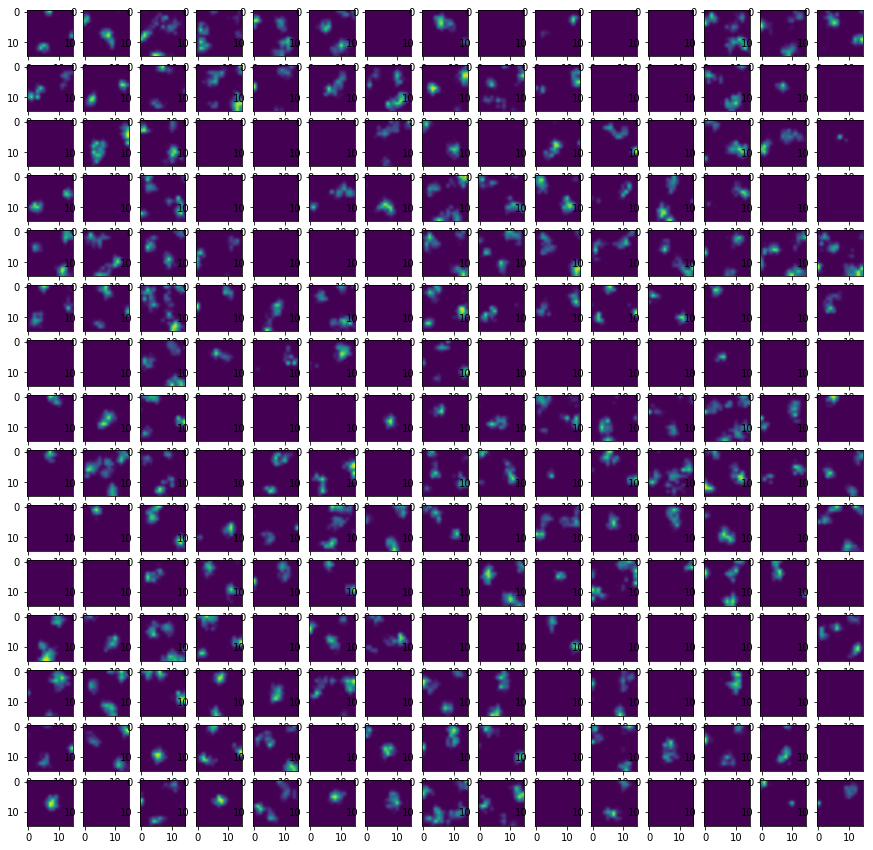

In [63]:
#plot_receptive_field(mgc.data.T, np.array(traj), plot_size=[20,15], bin_length=int(len(traj)/15), fig_size=[15,15])
plot_receptive_field(mpc.data.T, traj2, plot_size=[15,15], bin_length=int(traj2.shape[0]/15), fig_size=[15,15])

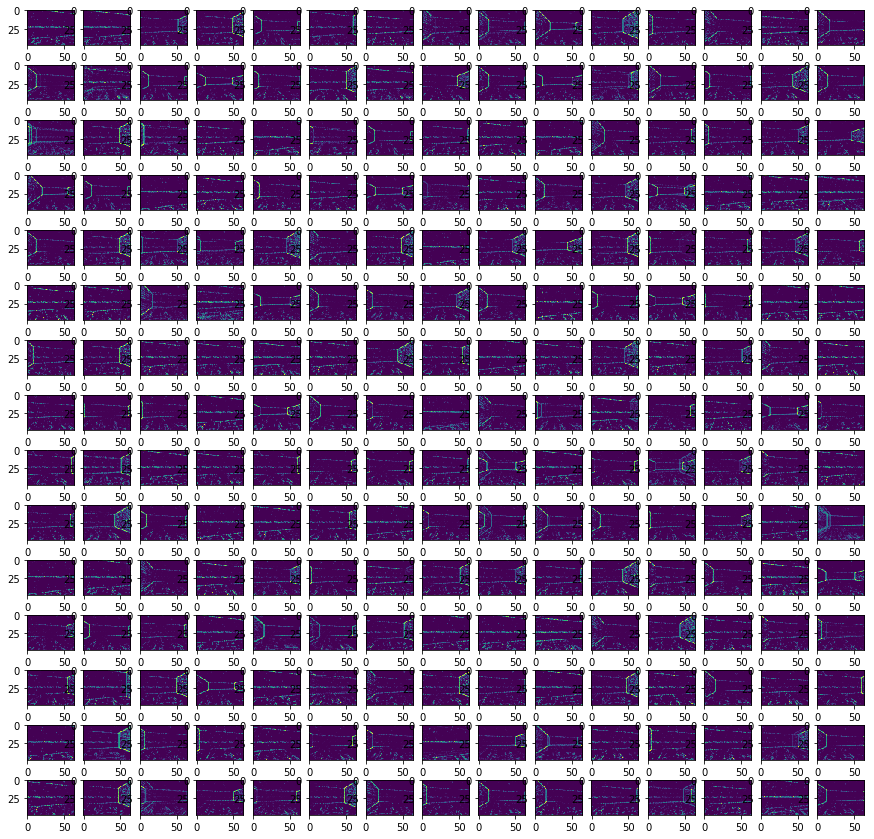

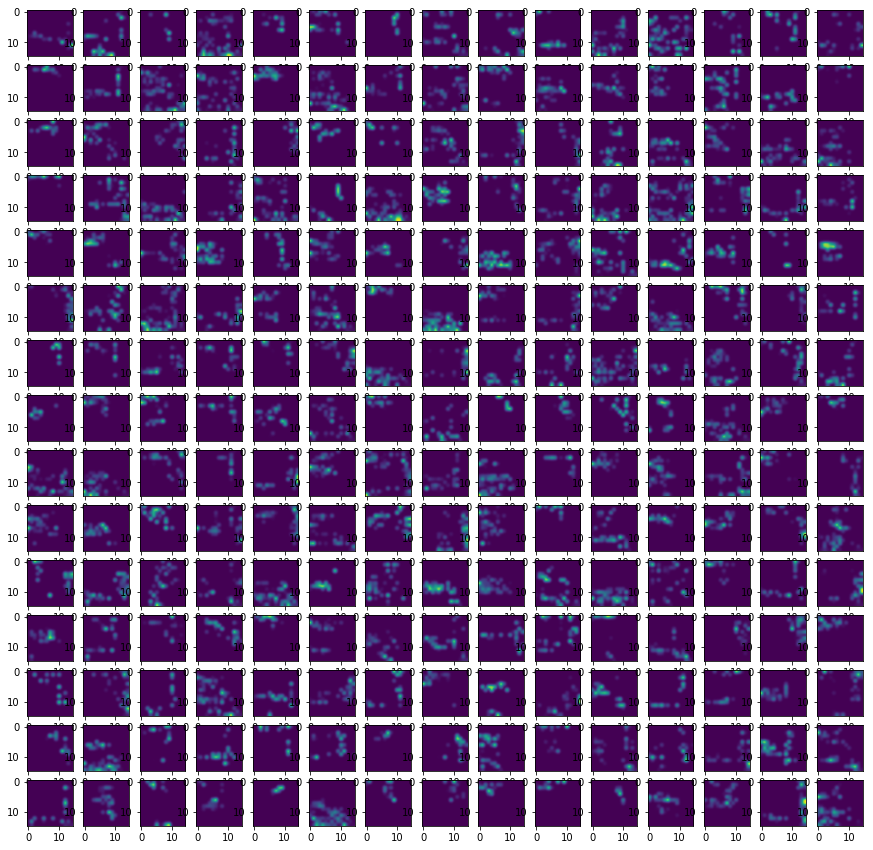

In [33]:
mapSize = [15,15]

# show the weight matrix
plt.figure(figsize = [15, 15]);
for pcIdx in np.arange(mapSize[0]*mapSize[1]):
    plt.subplot(mapSize[0], mapSize[1], pcIdx + 1);
    plt.imshow(vpc.w[:, pcIdx].reshape(v1.vn_height, v1.vn_width));
plt.show();

# estimation
plot_receptive_field(vpc.data.T, traj2, plot_size=[15,15], bin_length=int(traj2.shape[0]/15), fig_size=[15,15])

In [66]:
plot_receptive_field(cpc.data[200:,:].T, traj2[200:,:], plot_size=[7,7], bin_length=int(traj2[200:,:].shape[0]/15), fig_size=[7,7])